n this chapter, you will learn how to work with Climate Data Sets (MACA v2 for the United states) stored in netcdf 4 format using open source Python.

After completing this chapter, you will be able to:

- Download MACA v2 climate data in netcdf 4 format
- Open and process netcdf4 data using xarray
- Export climate data in tabular format to .csv format

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# netcdf4 needs to be installed in your environment for this to work
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

# Optional - set your working directory if you wish to use the data
# accessed lower down in this notebook (the USA state boundary data)
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

## Get Started wtih MACA Version 2 Data Using Open Source

In this lesson you will work with historic projected MACA 2 data that represents maximum monthly temperature for the Continental United States (CONUS).

#### agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly

The file name itself tells you a lot about the data.

- **macav2metdata:** the data are the MACA version two data which are downsampled to the extent of the continental United S tates
- **tasmax:** Max temperature is the parameter contained within the data
- **BNU-ESM:** This is the climate (CLM) model used to generate the data
- **historical:** these data are the modeled historical values for the years 1950 - 2005
- **CONUS:** These data are for the CONtinental United States boundary
- **monthly:** These data are aggregated monthly (rather than daily)


You will use the **xarray** package which requires the netcdf4 package to work with netcdf data. 

To begin, you open up the data using **xarray.open_dataset.**

In [2]:
# The (online) url for the MACAv2 data
data_path = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly.nc"

# Open the data using a context manager
with xr.open_dataset(data_path) as file_nc:
    # You can open the data using the code below, however it you use rio.write_crs
    # it will ensure that crs for your data persist throughout your analysis
    # max_temp_xr = file_nc
    max_temp_xr = file_nc.rio.write_crs(file_nc.rio.crs, inplace=True)

# View xarray object
max_temp_xr

<xarray.Dataset>
Dimensions:          (lat: 585, lon: 1386, time: 672)
Coordinates:
  * lat              (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * lon              (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time             (time) object 1950-01-15 00:00:00 ... 2005-12-15 00:00:00
    crs              int32 0
Data variables:
    air_temperature  (time, lat, lon) float32 ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

By default xarray does not handle spatial operations. However, if you load **rioxarray** it adds additional spatial functionality (supported by rasterio that supports handling:

- coordinate reference systems
- reprojection
- clipping

and more. Below you grab the coordinate reference system of the climate data using the .rio.crs method that is available because you have rioxarray loaded in this notebook.                                                                                                                               

In [3]:
# For later - grab the crs of the data using rioxarray
climate_crs = max_temp_xr.rio.crs
climate_crs

CRS.from_wkt('GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6378137,298.257223563]],PRIMEM["undefined",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

### Work With the NetCDF Data Structure - A Hierarchical Data Format
The object above is hierarchical and contains metadata making it self-describing. There are three dimensions to consider when working with this data which represent the x,y and z dimensions of the data:

- 1.latitude
- 2.longitude
- 3.time

The latitude and longitude dimension values reprensent an arrya containing the point location value of each pixel in decimal degrees. These are location of each pixel in your data. The time array similarly represents the time location for each array in the data cube. This particular dataset contains historical modeleled monthly max temperature values for the Continental United States.

In [4]:
# View first 5 latitude values
max_temp_xr["air_temperature"]["lat"].values[:5]

print("The min and max latitude values in the data is:", 
      max_temp_xr["air_temperature"]["lat"].values.min(), 
      max_temp_xr["air_temperature"]["lat"].values.max())
print("The min and max longitude values in the data is:", 
      max_temp_xr["air_temperature"]["lon"].values.min(), 
      max_temp_xr["air_temperature"]["lon"].values.max())


The min and max latitude values in the data is: 25.063077926635742 49.39602279663086
The min and max longitude values in the data is: 235.22784423828125 292.93524169921875


In [5]:
max_temp_xr["air_temperature"]["time"].values.shape

(672,)

Time is the z dimension. In this dataset you have **672 months worth of data.**

These data are spatial and thus have a coordinate reference system associated with them. You can access this information using .crs

HINT max_temp_xr["crs"] should also work!

Below, you use **.rio.crs to access** the CRS information rather than .crs. Rioxarray generally does a better job of accessing data attributes

In [6]:
# The data are lat/long (not projected)
max_temp_xr.rio.crs

CRS.from_wkt('GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6378137,298.257223563]],PRIMEM["undefined",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

## Hierarchical Formats Are Self Describing
Hierarchical data formats are self-describing. This means that the metadata for the data are contained within the file itself. **xarray stores metadata in the .attrs part of the file structure using a Python dictionary structure**. You can view the metadata using .attrs.

In [7]:
# View metadata
metadata = max_temp_xr.attrs
metadata

{'description': 'Multivariate Adaptive Constructed Analogs (MACA) method, version 2.3,Dec 2013.',
 'id': 'MACAv2-METDATA',
 'naming_authority': 'edu.uidaho.reacch',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'Metadata_Link': '',
 'cdm_data_type': 'FLOAT',
 'title': 'Monthly aggregation of downscaled daily meteorological data of Monthly Average of Daily Maximum Near-Surface Air Temperature from College of Global Change and Earth System Science, Beijing Normal University (BNU-ESM) using the run r1i1p1 of the historical scenario.',
 'summary': 'This archive contains monthly downscaled meteorological and hydrological projections for the Conterminous United States at 1/24-deg resolution. These monthly values are obtained by aggregating the daily values obtained from the downscaling using the Multivariate Adaptive Constructed Analogs (MACA, Abatzoglou, 2012) statistical downscaling method with the METDATA (Abatzoglou,2013) training dataset. The downscaled meteorological vari

In [8]:
# Above you grabbed the metadata (which is a dictionary)
# Here you can print any part of the dictionary that you wish to
metadata["title"]

'Monthly aggregation of downscaled daily meteorological data of Monthly Average of Daily Maximum Near-Surface Air Temperature from College of Global Change and Earth System Science, Beijing Normal University (BNU-ESM) using the run r1i1p1 of the historical scenario.'

## Subsetting or “Slicing” Your Data
You can quickly and efficiently slice and subset your data using xarray. Below, you will learn how to **slice the data using the .sel() method.**

This will return exactly two data points at the location - the temperature value for each day in your temporal slice.

In [9]:
# Select a single x,y combination from the data
key=400
longitude = max_temp_xr["air_temperature"]["lon"].values[key]
latitude = max_temp_xr["air_temperature"]["lat"].values[key]

print("Long, Lat values:", longitude, latitude)

Long, Lat values: 251.89422607421875 41.72947692871094


Below, you can see the x, y location that for the latitude/longitude location that you will use to slice the data above plotted on a map. The code below is an example of **creating a spatial plot using the cartopy package that shows the locationthat you selected.** This step is optional.

<ipython-input-10-966a4fd263cf>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  ax.plot(longitude-360, latitude,


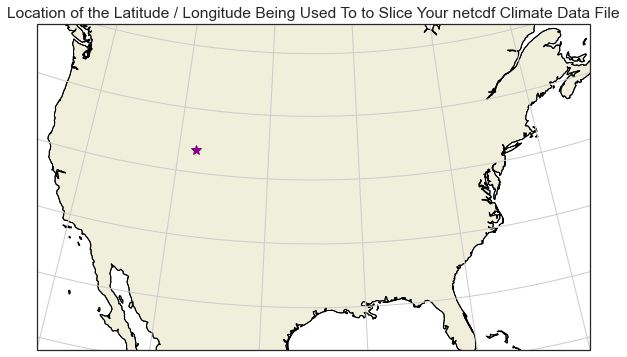

In [10]:
# Create a spatial map of your selected location with cartopy
extent = [-120, -70, 24, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

f, ax = plt.subplots(figsize=(12, 6),
                     subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
ax.coastlines()
# Plot the selected location 
ax.plot(longitude-360, latitude, 
        'r*', 
        transform=ccrs.PlateCarree(),
       color="purple", markersize=10)

ax.set_extent(extent)
ax.set(title="Location of the Latitude / Longitude Being Used To to Slice Your netcdf Climate Data File")

# Adds continent boundaries to the map
ax.add_feature(cfeature.LAND, edgecolor='black')

ax.gridlines()
plt.show()

Now it is time to subset the data for the point location that you are interested in (the lat / lon value that you plotted above). **You can slice the data for one single latitude, longitude location using the .sel() method.**

When you slice the data using one single point, your output for every (monthly in this case) time step in the data will be a single pixel value representing max temperature.

In [11]:
# Slice the data spatially using a single lat/lon point
one_point = max_temp_xr["air_temperature"].sel(lat=latitude, lon=longitude)
one_point

<xarray.DataArray 'air_temperature' (time: 672)>
array([271.11615, 274.05585, 279.538  , ..., 286.85074, 279.6746 , 271.4411 ],
      dtype=float32)
Coordinates:
    lat      float64 41.73
    lon      float64 251.9
  * time     (time) object 1950-01-15 00:00:00 ... 2005-12-15 00:00:00
    crs      int32 0
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

When you slice the data by a single point, notice that output data only has a single array of values. In this case these values represent air temperature (in K) over time.

In [12]:
# Notice the shape of the output array
one_point.shape

(672,)

The data stored in the xarray object is a numpy array. You can process the data in the same way you would process any other numpy array.

In [13]:
# View the first 5 values for that single point
one_point.values[:5]

array([271.11615, 274.05585, 279.538  , 284.42365, 294.1337 ],
      dtype=float32)

### Plot A Time Series For a Single Location
Above you used a single point location to slice your data. Because the data are for only one location, but over time, you can quickly **create a scatterplot of the data using objectname.plot().**

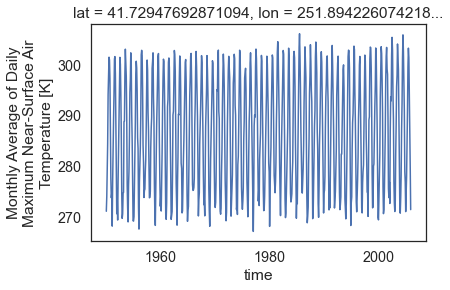

In [14]:
# Use xarray to create a quick time series plot
one_point.plot.line()
plt.show()

You can make the plot a bit prettier if you’d like using the standard Python matplotlib plot parameters. Below you change the marker color to purple and the lines to grey. figsize is used to adjust the size of the plot.

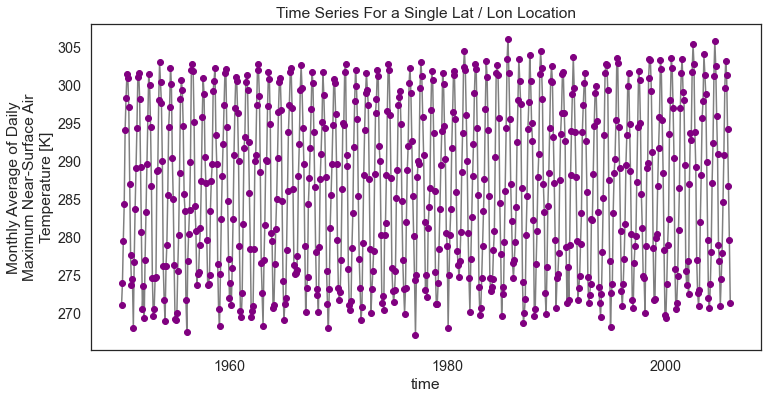

In [15]:
# You can clean up your plot as you wish using standard matplotlib approaches
f, ax = plt.subplots(figsize=(12, 6))
one_point.plot.line(hue='lat',
                    marker="o",
                    ax=ax,
                    color="grey",
                    markerfacecolor="purple",
                    markeredgecolor="purple")
ax.set(title="Time Series For a Single Lat / Lon Location")

# Uncomment the line below if you wish to export the figure as a .png file
# plt.savefig("single_point_timeseries.png")
plt.show()

### Convert Climate Time Series Data to a Pandas DataFrame & Export to a .csv File
You can convert your data to a DataFrame and export to a .csv file using **to_dataframe() and to_csv().**

In [16]:
# Convert to dataframe -- then this can easily be exported to a csv
one_point_df = one_point.to_dataframe()
# View just the first 5 rows of the data
one_point_df.head()

,lat,lon,crs,air_temperature
time,,,,
1950-01-15 00:00:00,41.729477,251.894226,0,271.116150
1950-02-15 00:00:00,41.729477,251.894226,0,274.055847
1950-03-15 00:00:00,41.729477,251.894226,0,279.537994
1950-04-15 00:00:00,41.729477,251.894226,0,284.423645
1950-05-15 00:00:00,41.729477,251.894226,0,294.133698


In [17]:
# Export data to .csv file
one_point_df.to_csv("one-location.csv")

## Slice Climate MACAv2 Data By Time and Location
**Above you sliced the data by spatial location, selecting only one point location at a specific latitude and longitude.** You can also slice the data by time. Below, you slice the data at the selected lat / long location and for a 5-year time period in the year 2000.

Notice that the output shape is 60. 60 represents 12 months a year over 5 years for the selected lat / lon location. Again because you are slicing out data for a single point location, you have a total of 60 data points in the output numpy array.

In [18]:
start_date = "2000-01-01"
end_date = "2005-01-01"
temp_2000_2005 = max_temp_xr["air_temperature"].sel(time=slice(start_date, end_date),
                                                    lat=45.02109146118164, lon=243.01937866210938)
temp_2000_2005

<xarray.DataArray 'air_temperature' (time: 60)>
array([273.74884, 277.1434 , 280.0702 , 280.6042 , 289.23993, 290.86853,
       297.70242, 301.36722, 296.4382 , 291.29434, 275.8434 , 273.0037 ,
       275.154  , 278.77863, 282.29105, 283.87787, 290.53387, 296.701  ,
       297.4607 , 301.16116, 295.5421 , 287.3863 , 276.85397, 274.35953,
       278.0117 , 275.68024, 282.12674, 286.41693, 292.4094 , 297.30606,
       300.84628, 302.10593, 288.83698, 288.44   , 276.38992, 276.5348 ,
       275.86145, 276.5708 , 280.8476 , 284.35712, 292.14087, 293.66147,
       301.09534, 302.7656 , 294.99573, 287.5425 , 277.80093, 273.25894,
       274.09232, 276.94736, 280.25446, 283.47614, 289.63776, 290.5187 ,
       301.8519 , 300.40402, 290.73633, 289.60886, 277.12424, 275.7836 ],
      dtype=float32)
Coordinates:
    lat      float64 45.02
    lon      float64 243.0
  * time     (time) object 2000-01-15 00:00:00 ... 2004-12-15 00:00:00
    crs      int32 0
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

In [19]:
temp_2000_2005.shape

(60,)

In [20]:
# View the 60 data points (raster cell values) associated with the spatial and temporal subset
temp_2000_2005.values

array([273.74884, 277.1434 , 280.0702 , 280.6042 , 289.23993, 290.86853,
       297.70242, 301.36722, 296.4382 , 291.29434, 275.8434 , 273.0037 ,
       275.154  , 278.77863, 282.29105, 283.87787, 290.53387, 296.701  ,
       297.4607 , 301.16116, 295.5421 , 287.3863 , 276.85397, 274.35953,
       278.0117 , 275.68024, 282.12674, 286.41693, 292.4094 , 297.30606,
       300.84628, 302.10593, 288.83698, 288.44   , 276.38992, 276.5348 ,
       275.86145, 276.5708 , 280.8476 , 284.35712, 292.14087, 293.66147,
       301.09534, 302.7656 , 294.99573, 287.5425 , 277.80093, 273.25894,
       274.09232, 276.94736, 280.25446, 283.47614, 289.63776, 290.5187 ,
       301.8519 , 300.40402, 290.73633, 289.60886, 277.12424, 275.7836 ],
      dtype=float32)

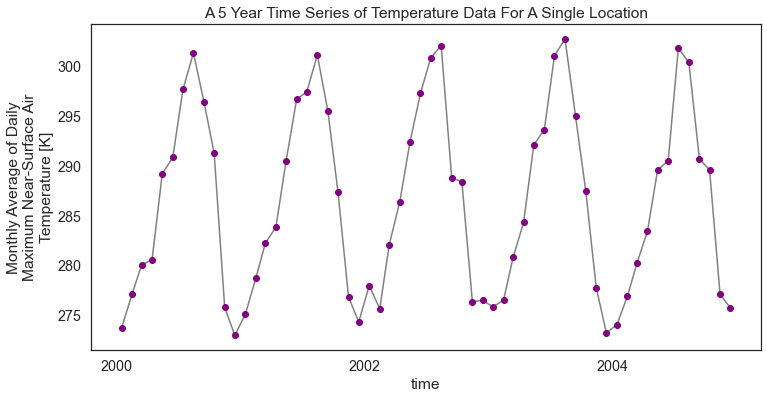

In [21]:
# Plot the data just like you did above
f, ax = plt.subplots(figsize=(12, 6))
temp_2000_2005.plot.line(hue='lat',
                         marker="o",
                         ax=ax,
                         color="grey",
                         markerfacecolor="purple",
                         markeredgecolor="purple")
ax.set(title="A 5 Year Time Series of Temperature Data For A Single Location")
plt.show()

### Convert Subsetted to a DataFrame & Export to a .csv File
Similar to what you did above, you can also convert your data to a DataFrame. Once your data are in a DataFrame format, you can quickly export a .csv file.

In [22]:
# Convert to dataframe -- then this can be exported to a csv if you want that
temp_2000_2005_df = temp_2000_2005.to_dataframe()
# View just the first 5 rows of the data
temp_2000_2005_df.head()

,lat,lon,crs,air_temperature
time,,,,
2000-01-15 00:00:00,45.021091,243.019379,0,273.748840
2000-02-15 00:00:00,45.021091,243.019379,0,277.143402
2000-03-15 00:00:00,45.021091,243.019379,0,280.070190
2000-04-15 00:00:00,45.021091,243.019379,0,280.604187
2000-05-15 00:00:00,45.021091,243.019379,0,289.239929


In [23]:
# Export to a csv file to share with your friends!
temp_2000_2005_df.to_csv("tempb_5years.csv")

## Slice The Data Across a Spatial Extent For A Specific Time Period

Below you select data for the entire CONUS (Continental United States) study area and analyze it as a spatial raster object.

Once again you use .sel() combined with slice() subset the data.

Notice below that if you don’t specify the lat and lon extent, it will by default return all of the pixels available in the data for the specified time period.

Notice that you are plotting the entire spatial extent of the data which is in this case called CONUS (CONtinental United States)  

In [24]:
start_date = "1950-01-15"
end_date = "1950-02-15"

two_months_conus = max_temp_xr["air_temperature"].sel(time=slice(start_date, end_date))
# Notice that time has a value of **2** below representing two time steps or months worth of data
two_months_conus

<xarray.DataArray 'air_temperature' (time: 2, lat: 585, lon: 1386)>
[1621620 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 25.06 25.1 25.15 25.19 ... 49.27 49.31 49.35 49.4
  * lon      (lon) float64 235.2 235.3 235.3 235.4 ... 292.8 292.9 292.9 292.9
  * time     (time) object 1950-01-15 00:00:00 1950-02-15 00:00:00
    crs      int32 0
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

In [25]:
two_months_conus.shape

(2, 585, 1386)

The default return when you plot an xarray object with multipple years worth of data across a spatial extent is a histogram.

When you call .plot() on the data, the default plot is a histogram representing the range of raster pixel values in your data for all time periods (2 months in this case).

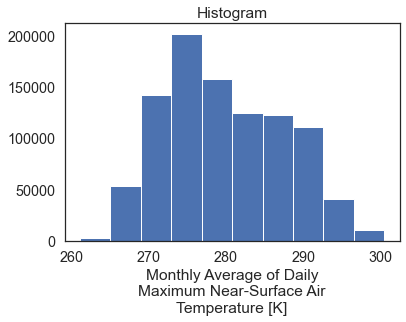

In [26]:
# Directly plot just a single day using time in "years"
two_months_conus.plot()
plt.show()

## Spatial Raster Plots of MACA v2 Climate Data
If you want to plot the data spatially as a raster, you can use .plot() but specify the lon and lat values as the x and y dimensions to plot. You can add the following parameters to your .plot() call to make sure each time step in your data plots spatially:

**col_wrap=2:** adjust how how many columns the each subplot is spread across **col=: what dimension is being plotted in each subplot.**

In this case, you want a single raster for each month (time step) in the data so you specify col='time'. col_wrap=1 forces the plots to stack on top of each other in your matplotlib figure.

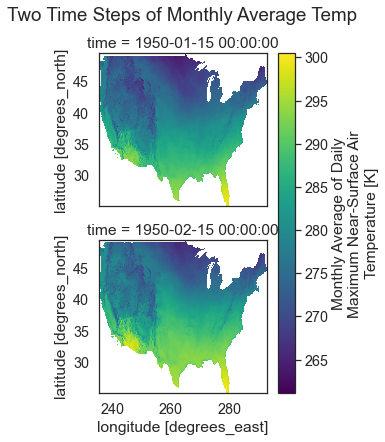

In [27]:
# Quickly plot the data using xarray.plot()
two_months_conus.plot(x="lon",
                      y="lat",
                      col="time",
                      col_wrap=1)
plt.suptitle("Two Time Steps of Monthly Average Temp", y=1.03)
plt.show()

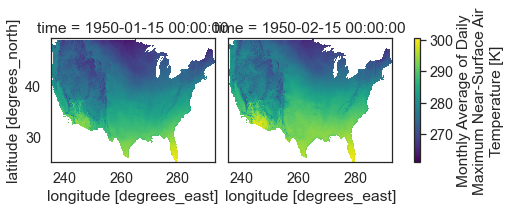

In [28]:
# Plot the data using 2 columns
two_months_conus.plot(x="lon",
                      y="lat",
                      col="time",
                      col_wrap=2)
plt.show()

Plot showing two months of the historic max temperature climate data plotted using xarray .plot(). If you set col_wrap to 2, then you end up with two columns.

## Plot Multiple MACA v2 Climate Data Raster Files With a Spatial Projection
Below you plot the same data using **cartopy which support spatial projectsion.** The coastlines() basemap is also added to the plot.

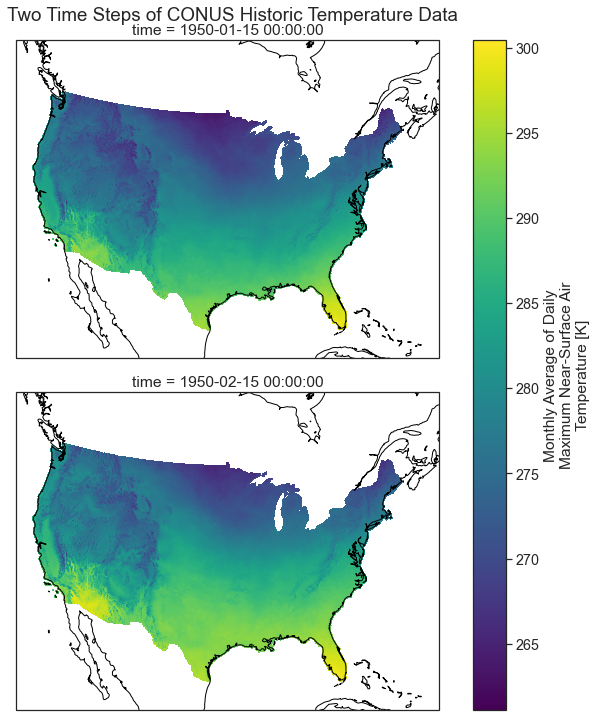

In [29]:
central_lat = 37.5
central_long = 96
extent = [-120, -70, 20, 55.5]  # CONUS

map_proj = ccrs.AlbersEqualArea(central_longitude=central_lon,
                                central_latitude=central_lat)

aspect = two_months_conus.shape[2] / two_months_conus.shape[1]
p = two_months_conus.plot(transform=ccrs.PlateCarree(),  # the data's projection
                          col='time', col_wrap=1,
                          aspect=aspect,
                          figsize=(10, 10),
                          subplot_kws={'projection': map_proj})  # the plot's projection

plt.suptitle("Two Time Steps of CONUS Historic Temperature Data", y=1)
# Add the coastlines to each axis object and set extent
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(extent)

## Export Raster to Geotiff File
In the above workflows you converted your data into a DataFrame and exported it to a .csv file. This approach works well if you only need the summary values and don’t need any spatial information. However sometimes you may need to export spatial raster files.

You can export your data to a geotiff file format using rioxarray. To do this you will need to:

- 1.ensure that your xarray object has a crs defined and define it if it’s missing.
- 2.call xarray to export your data

Notice below that your two month subset no long contains CRS information.

In [30]:
# Double check the crs still exist
two_months_conus.rio.crs

CRS.from_wkt('GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6378137,298.257223563]],PRIMEM["undefined",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

At the very beginning of this lesson, you saved the crs information from the original xarray object. You can use that to export your geotiff data below.

Once the crs is set, you can export to a geotiff file format.

In [39]:
two_months_conus.shape

(2, 585, 1386)

In [32]:
type(two_months_conus)

xarray.core.dataarray.DataArray

In [37]:
# Export to geotiff
file_path = f"C:/capes_sql/colorado-flood/outputs/two_months_temp_data.tif"
file_path

'C:/capes_sql/colorado-flood/outputs/two_months_temp_data.tif'

In [38]:
two_months_conus.rio.to_raster(file_path)

ValueError: failed to prevent overwriting existing key grid_mapping in attrs. This is probably an encoding field used by xarray to describe how a variable is serialized. To proceed, remove this key from the variable's attributes manually.

https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/use-netcdf-in-python-xarray/ 